# Variational Quantum Eigensolvers

Let's first start by importing implemented VQE class, and helpers. We will also need qiskit for generic pauli operators.

In [1]:
from VQEs.VQE import VQE
from VQEs.Helpers import *
from qiskit import *
import numpy as np

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Let's start with a very simple matrix to show to usage of VQE. 

Our aim is to find the lowest eigenvalue of the following matrix

$$
U = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

using VQE circuit. In order to do so, one must find a decomposition of the  $U$ in terms of Pauli operators $\{\mathbb{1}, X, Y, Z\}$:

$$
\mathbb{1} =
\begin{bmatrix}
1 & 0  \\
0 & 1
\end{bmatrix}\quad
X =
\begin{bmatrix}
0 & 1 \\
1& 0
\end{bmatrix}\quad
Y =
\begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix}\quad
Z =
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

in order to be implemented on a quantum computer. In particular, since we are dealing with a $4\times4$ matrix, two qubits are needed, thus the desired decomposition will be made of *tensor products* of two Pauli operators (e.g. $X_1 \otimes Y_2$, where the subscript denotes the system on which the operator acts).

For this I impelemted a function named ```decomposeHamiltonian(H)```

In [2]:
U = np.array([[1, 0, 0, 0], 
              [0, 0, -1, 0], 
              [0, -1, 0, 0],
              [0, 0, 0, 1]])

Using ```decomposeHamiltonian(H)``` we can see the decomposed U into paulis.

In [3]:
decomposedU = decomposeHamiltonian(U)
print(decomposedU)

0.5 * II
- 0.5 * XX
- 0.5 * YY
+ 0.5 * ZZ


We can also see this term is really equal to original U.

In [4]:
decomposedU.to_matrix()

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

We can initialize our VQE object just with our only required parameter matrix(we can both use ```PauliSumOp``` of Qiskit or a numpy array). We will use this object to optimize parameters and also show the final ansatz.

In [5]:
vqe = VQE(decomposedU)

Then, if we just run the VQE algorithm with defined ```run(plotIterations=True)``` function we can get our optimization result and a plot for iteration expectations values.
Also lets compare the results with exact ground state energy of U.

The exact ground state energy : -1.0000000000000002
The estimated ground state energy from VQE algorithm : -0.9951171875
Iteration count for convergence : 117
Measurement shot count per iteration: 8192
Optimizer COBYLA tolerance: 0.001


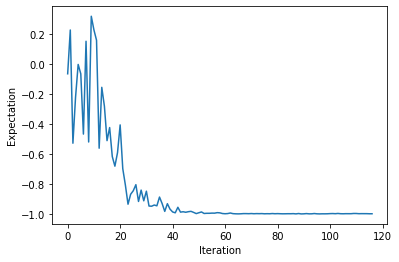

In [6]:
from qiskit.algorithms import NumPyEigensolver

classicalEigenSolver = NumPyEigensolver(k=1) # gets the lowest eigenvalue
result = classicalEigenSolver.compute_eigenvalues(decomposedU)
referenceEigenValueU = np.real(result.eigenvalues.flat[0])

print("The exact ground state energy : {}".format(referenceEigenValueU))
result = vqe.run()
print("The estimated ground state energy from VQE algorithm : {}".format(result.fun))
print("Iteration count for convergence : {}".format(result.nfev))
print("Measurement shot count per iteration: {}".format(vqe.shots))
print("Optimizer {} tolerance: {}".format(vqe.optimizer, vqe.tol))

We can also see the final ansatz with its optimized parameters with ```draw()``` function.

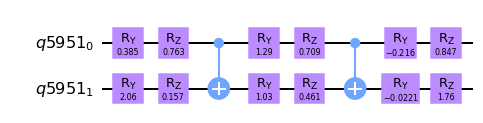

In [7]:
vqe.draw(output='mpl')

Let's now try VQE with a real molecule Hamiltonian.

### Molecule Setup

The hydrogen molecule (H$_2$) at the equilibrium bond length (0.735 Angstrom) will be used. In order to set up the molecular Hamiltonian one has to get the one- and two-electron integrals from a computational chemistry driver (PySCF in this case). The information from the driver is saved in the ``molecule`` object. Then the Fermionic Hamiltonian is mapped to the qubit Hamiltonian using the ``parity`` mapping type as it further reduces the problem size.

In [8]:
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.operators.legacy.op_converter import to_weighted_pauli_operator

driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735',
                     unit=UnitsType.ANGSTROM,
                     basis='sto3g')
molecule = driver.run()
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)

# Build the qubit operator, which is the input to the VQE algorithm
map_type = 'PARITY'
qubitOp = ferOp.mapping(map_type)
qubitOp = Z2Symmetries.two_qubit_reduction(to_weighted_pauli_operator(qubitOp), num_particles)
num_qubits = qubitOp.num_qubits

Let's see how our Hamiltonian looks as matrix and pauli sum operator. 

In [9]:
H = qubitOp.to_opflow().to_matrix()
decomposedH = decomposeHamiltonian(H)
print("Hamiltonian Matrix: \n{}\n".format(H))
print("Decomposed Hamiltonian: \n{}".format(decomposedH))

Hamiltonian Matrix: 
[[-1.06365335+0.j  0.        +0.j  0.        +0.j  0.1809312 +0.j]
 [ 0.        +0.j -1.83696799+0.j  0.1809312 +0.j  0.        +0.j]
 [ 0.        +0.j  0.1809312 +0.j -0.24521829+0.j  0.        +0.j]
 [ 0.1809312 +0.j  0.        +0.j  0.        +0.j -1.06365335+0.j]]

Decomposed Hamiltonian: 
-1.05237324577286 * II
+ 0.39793742484317907 * IZ
+ 0.1809311997842313 * XX
- 0.39793742484317907 * ZI
- 0.01128010425623538 * ZZ


Now we can again initialize our VQE instance and compute analytical ground state energy.

In [10]:
vqeH2 = VQE(H)

result = classicalEigenSolver.compute_eigenvalues(decomposedH)
referenceEigenValueH = np.real(result.eigenvalues.flat[0])

The exact ground state energy : -1.8572750302023822
The estimated ground state energy from VQE algorithm : -1.851117484631565
Iteration count for convergence : 118
Measurement shot count per iteration: 8192
Optimizer COBYLA tolerance: 0.001


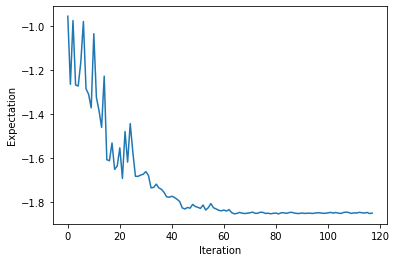

In [11]:
print("The exact ground state energy : {}".format(referenceEigenValueH))
result = vqeH2.run()
print("The estimated ground state energy from VQE algorithm : {}".format(result.fun))
print("Iteration count for convergence : {}".format(result.nfev))
print("Measurement shot count per iteration: {}".format(vqeH2.shots))
print("Optimizer {} tolerance: {}".format(vqeH2.optimizer, vqeH2.tol))

Ansatz with parameters : 
[ 2.04413384  0.2882832   2.90870521  1.35194768  0.38237203 -0.24108451
  1.65190948  1.78248712  1.26511828 -0.10662816  0.21347281  1.01279414]


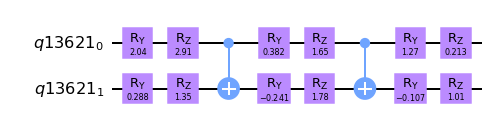

In [12]:
print("Ansatz with parameters : \n{}".format(result.x))
vqeH2.draw(output='mpl')

We demonstrate the calculation of the ground state energy for LiH at various interatomic distances. A driver for the molecule must be created at each such distance. Note that in this experiment, to reduce the number of qubits used, we freeze the core and remove two unoccupied orbitals. First, we define a function that takes an interatomic distance and returns the appropriate qubit operator, $H$, as well as some other information about the operator.

Reference: https://qiskit.org/textbook/ch-applications/vqe-molecules.html

In [1]:
import numpy as np 
import pylab 
import copy
from qiskit import BasicAer 
from qiskit.aqua import aqua_globals, QuantumInstance 
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE 
from qiskit.aqua.components.optimizers import SLSQP 
from qiskit.chemistry.components.initial_states import HartreeFock 
from qiskit.chemistry.components.variational_forms import UCCSD 
from qiskit.chemistry.drivers import PySCFDriver 
from qiskit.chemistry.core import Hamiltonian, QubitMappingType
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
distances = np.arange (0.5,4.25,0.25)
vqe_energies = []
hf_energies = []
exact_energies = []

/home/ricky/anaconda3/envs/seminar/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/ricky/anaconda3/envs/seminar/lib/python3.8/site-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


In [2]:
for i, d in enumerate (distances):
    print('step',i)
    #set up experiment
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run ()
    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                        two_qubit_reduction=True, freeze_core=True,
                          orbital_reduction=[-3,-2])
    qubit_op, aux_ops = operator.run (qmolecule)
    #exact classical result
    exact_result = NumPyMinimumEigensolver (qubit_op,aux_operators=aux_ops).compute_minimum_eigenvalue() 
    exact_result = operator.process_algorithm_result(exact_result)
    #VQE
    optimizer = SLSQP (maxiter=1000)
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                                operator.molecule_info['num_particles'],
                                qubit_mapping=operator._qubit_mapping,
                                two_qubit_reduction=operator._two_qubit_reduction)
    #VQE
    optimizer = SLSQP (maxiter=1000)
    initial_state = HartreeFock (operator.molecule_info['num_orbitals'],
                                operator.molecule_info['num_particles'],
                                qubit_mapping=operator._qubit_mapping,
                                two_qubit_reduction=operator._two_qubit_reduction)
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                    num_particles=operator.molecule_info['num_particles'],
                    initial_state=initial_state,
                    qubit_mapping=operator._qubit_mapping,
                    two_qubit_reduction=operator._two_qubit_reduction)
    algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
    vqe_result=algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)
    exact_energies.append(exact_result.energy)
    vqe_energies.append (vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

step 0


/tmp/ipykernel_5368/446905631.py:6: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
/home/ricky/anaconda3/envs/seminar/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:88: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/ricky/anaconda3/envs/seminar/lib/python3.8/site-packages/qiskit/chemistry/fermionic_operator.py:386: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/bl

step 1


/home/ricky/anaconda3/envs/seminar/lib/python3.8/site-packages/qiskit/chemistry/components/initial_states/hartree_fock.py:61: DeprecationWarning: The HartreeFock class is deprecated as of Aqua 0.9 and will be removed no earlier than 3 months after the release date. Instead, all algorithms and circuits accept a plain QuantumCircuit. 
  super().__init__()


step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14


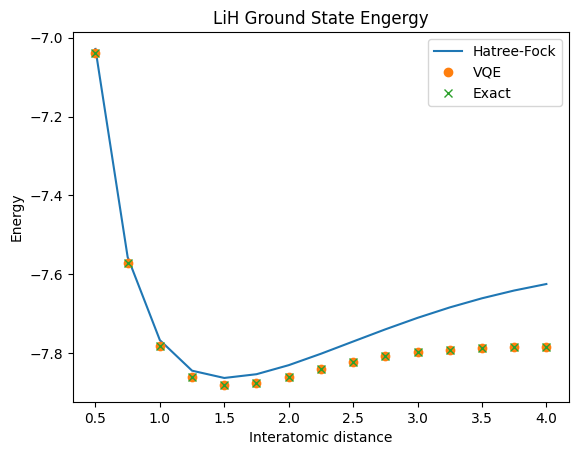

In [3]:
pylab.plot(distances, hf_energies, label='Hatree-Fock')
pylab.plot(distances, vqe_energies, 'o',label='VQE')
pylab.plot(distances, exact_energies, 'x',label='Exact')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Engergy')
pylab.legend(loc='upper right')

## Future Improvements
- Try VQEs with real quantum devices with IBM backend.
- qubit-ADAPT-VQE uses complete minimal pool, but in the first iteration even if we start from Hartree Fock state there is a chance of gradient $\langle \psi | [H, \hat{A}] | \psi \rangle $ gives 0(practically is not zero but smaller than threshold) for all pool operators depending on hamiltonian. We can try to start from different initial states $ | \psi \rangle$ to overcome this, I used a simple workaround such as even if the gradients are below threshold in the first iteration, I added the operator with maximum gradient norm to ansatz to make it possible to grow more.

- As you can see in the iteration results, even if the norm of the gradient is bigger than threshold, it doesn't necessarily improve the eigenvalue estimation. As an improvement, we can hold the eigenvalue estimations and circuits until final iteration and if it doesn't converge until maximum iteration count(circuit depth) we can return the minimum estimation eigenvalue with its ansatz.